1. efficientnet-b0 모델로 학습


2. 식물 소분류, 300에폭

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/lukemelas/EfficientNet-PyTorch

Cloning into 'EfficientNet-PyTorch'...
remote: Enumerating objects: 665, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 665 (delta 26), reused 58 (delta 23), pack-reused 595
Receiving objects: 100% (665/665), 1.14 MiB | 26.58 MiB/s, done.
Resolving deltas: 100% (341/341), done.


In [ ]:
%cd EfficientNet-PyTorch

/content/EfficientNet-PyTorch


In [ ]:
!pip install -e .

Obtaining file:///content/EfficientNet-PyTorch
  Preparing metadata (setup.py) ... done
  Running setup.py develop for efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 429MB/s]

Loaded pretrained weights for efficientnet-b0


#  이 model을 transfer-learning으로 학습


EfficientNet은 ImageNet에 맞춰 학습되있으므로 마지막 출력 차원이 1000차원임 -> 1000개 중 한개를 고르는 식.


내가 customize해서 모델을 구성할 땐 출력차원을 조정해줘야 한다.

모델은 2단계로 나뉜다.

1. CNN을 이용한 특징(feature) 추출(이미지 -> 특징, [1, 3, 224, 224] -> [1, 1280, 7, 7])
(기본이 224로 되어있음)


    나는 이걸 [1, 3, 224, 224] -> [1, 1280, 14, 14])

2. 특징(feature)을 이용하여 Linear-layer 후 Softmax로 분류(1, 1280, 7, 7) -> (1, 1000)


    나는 이걸 [1, 1280, 14, 14] -> (1, 1000))


이 중 2단계를 내 입맛에 맞게 바꾼다. Softmax 출력을 14로 바꾸자

(내 custom dataset은 사진이 주워졌을 때 14개 클래스 중 뭐냐





In [ ]:
from efficientnet_pytorch import EfficientNet
import torch
from torchvision import transforms
from PIL import Image

model = EfficientNet.from_pretrained('efficientnet-b0')

# Load and preprocess an image
image_path = '/content/drive/My Drive/은세연아/연아/data/식물/가시박/1.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by the model
    transforms.ToTensor(),           # Convert to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])
img = preprocess(image).unsqueeze(0)  # Add a batch dimension

# Create an EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Extract features
features = model.extract_features(img)

print(features.shape)  # torch.Size([1, 1280, 7, 7])


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
torch.Size([1, 1280, 7, 7])


In [ ]:
# import torch.nn.functional as F

# # 특징을 (1, 1280, 14, 14)로 업샘플링
# features_upsampled = F.interpolate(features, size=(14, 14), mode='bilinear', align_corners=False)

# print(features_upsampled.shape)

# # features의 크기를 features_upsampled와 일치하도록 조정합니다.
# features = F.interpolate(features, size=(14, 14), mode='bilinear', align_corners=False)

# print(features.shape)

In [ ]:
## 학습 코드
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=14)

print(features.shape)

224
Loaded pretrained weights for efficientnet-b0
torch.Size([1, 1280, 7, 7])


image size = 224


features_upsampled --> torch.Size([1, 1280, 14, 14])

*  미리 학습된 weight들은 고정하고 뒷부분 2단계만 학습하고 싶다면 아래 코드를 추가

In [ ]:
# fc 제외하고 freeze
# for n, p in model.named_parameters():
#     if '_fc' not in n:
#         p.requires_grad = False
# model = torch.nn.parallel.DistributedDataParallel(model)

### 데이터 로드

In [ ]:
data_path = '/content/drive/My Drive/은세연아/은세/image_dataset/대분류'

# 디렉토리에서 클래스 레이블을 추출합니다.
class_labels = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# 추출된 클래스 레이블을 출력합니다.
print(class_labels)
print(len(class_labels))

['양서파충류', '어류', '육상곤충', '식물', '조류', '포유류']
6


데이터 로딩 및 전처리 단계에서는 (1, 1280, 14, 14) 이미지를 사용하고, 모델을 통과한 후에 (1, 1000) 차원의 출력을 얻게 됩니다

In [ ]:
# # 모델 출력에 적용되는 (1,1000)
# import torch.nn as nn

# # 새로운 Linear 레이어를 정의합니다.
# linear_layer = nn.Linear(1280 * 14 * 14, 1000)

# # 평탄화(flatten)된 피처에 새로운 Linear 레이어를 적용합니다.
# output = linear_layer(features_upsampled.view(1, -1))
# output_softmax = F.softmax(output, dim=1)

In [ ]:
## 데이타 로드!!
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'


batch_size  = 128
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

## make dataset
from torchvision import transforms, datasets
data_path = '/content/drive/My Drive/은세연아/은세/image_dataset/대분류' # class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다

object_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]))

In [ ]:
## data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

train_idx, tmp_idx = train_test_split(list(range(len(object_dataset))), test_size=0.2, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(object_dataset, train_idx)
tmp_dataset       = Subset(object_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test']  = Subset(tmp_dataset, test_idx)

## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)

dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)

dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)

batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 128,  tvt : 18 / 3 / 3


In [ ]:
# 한글 폰트
# 한글 폰트 적용
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')

import os

!apt-get -qq install fonts-nanum

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
    name='NanumBarunGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumBarunGothic'})

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (4,990 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and dire

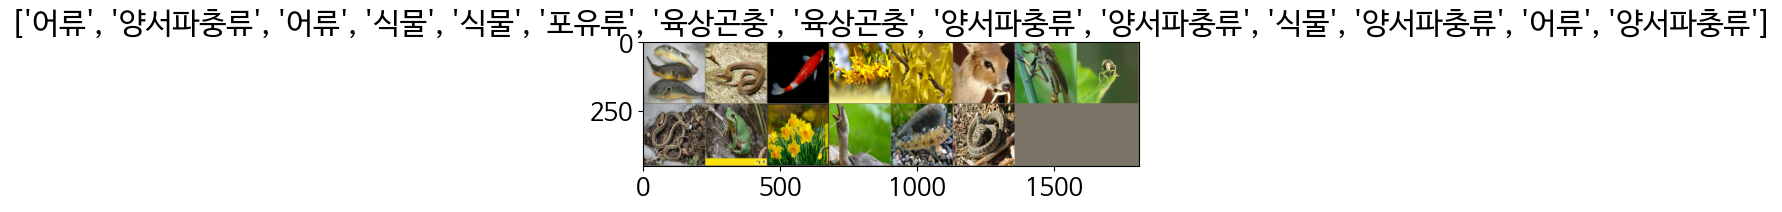

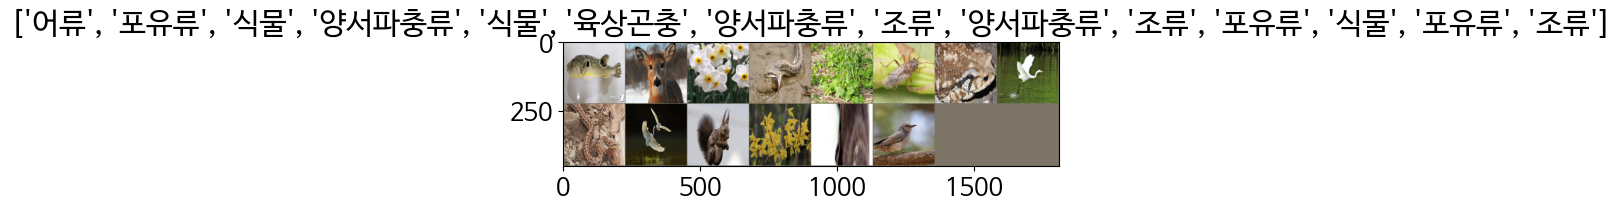

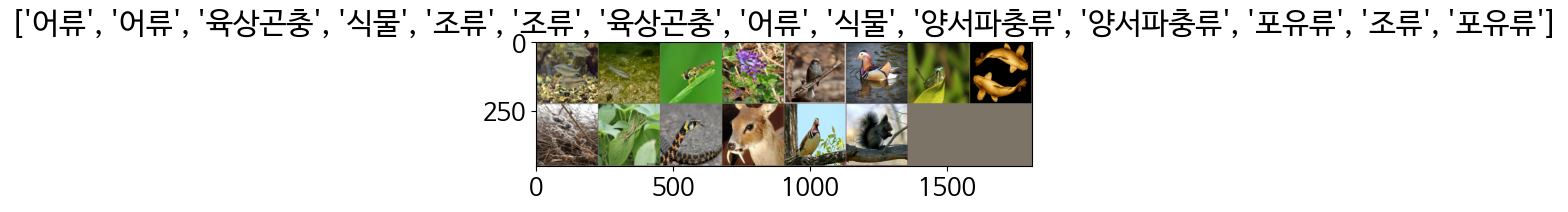

In [ ]:
## 데이터 체크
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 14

class_names = {
    "0": "식물",       #  "가시박" 6
    "1": "양서파충류",         # "갈풀" 6
    "2": "어류",         # "개나리" 6
    "3": "육상곤충",      # "갯버들" 6
    "4": "조류",     # ""긴병풀꽃" 6
    "5": "포유류",   #  "달뿌리풀" 6
    }

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려붙임
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려붙임
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려붙임
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()

            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'object_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(),
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [ ]:
# !pip3 install numpy --pre torch torchvision torchaudio --force-reinstall --index-url https://download.pytorch.org/whl/nightly/cu117
!pip3 install torchvision

In [ ]:
# CUDA_LAUNCH_BLOCKING=1
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 0.99 Acc: 78.6
valid Loss: 0.11 Acc: 96.9
==> best model saved - 0 / 96.9
Epoch 1/99
----------
train Loss: 0.07 Acc: 98.2
valid Loss: 0.10 Acc: 97.2
==> best model saved - 1 / 97.2
Epoch 2/99
----------
train Loss: 0.03 Acc: 99.0
valid Loss: 0.09 Acc: 96.9
Epoch 3/99
----------
train Loss: 0.01 Acc: 99.6
valid Loss: 0.06 Acc: 98.6
==> best model saved - 3 / 98.6
Epoch 4/99
----------
train Loss: 0.01 Acc: 99.8
valid Loss: 0.08 Acc: 98.3
Epoch 5/99
----------
train Loss: 0.01 Acc: 99.8
valid Loss: 0.04 Acc: 99.0
==> best model saved - 5 / 99.0
Epoch 6/99
----------
train Loss: 0.00 Acc: 99.9
valid Loss: 0.03 Acc: 99.0
Epoch 7/99
----------
train Loss: 0.00 Acc: 100.0
valid Loss: 0.03 Acc: 98.6
Epoch 8/99
----------
train Loss: 0.00 Acc: 100.0
valid Loss: 0.03 Acc: 98.6
Epoch 9/99
----------
train Loss: 0.00 Acc: 100.0
valid Loss: 0.04 Acc: 98.6
Epoch 10/99
----------
train Loss: 0.00 Acc: 100.0
valid Loss: 0.03 Acc: 98.6
Epoch 11/99
----------
train Lo

best model : 29 - 99 / 0.0


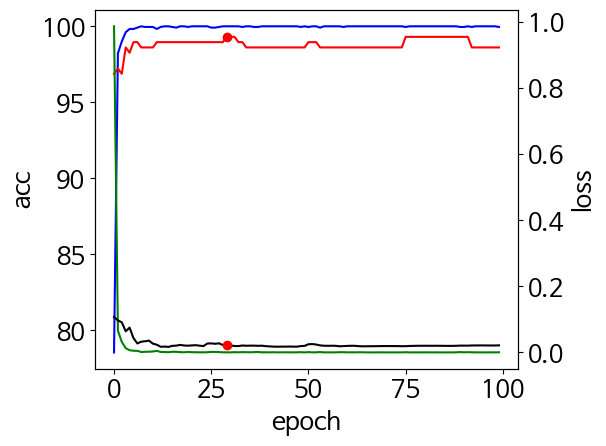

In [ ]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-') #파란색 실선= train_acc
ax1.plot(valid_acc, 'r-') #빨간색 실선= valid_acc
plt.plot(best_idx, valid_acc[best_idx], 'ro') #최상의모델의 valid_acc를 빨간원(ro)
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-') # 초록색 = train_loss
ax2.plot(valid_loss, 'k-') # 검정색 = vaild_loss
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

best model : 4 - 99 / 0.1


**4번째 에폭에서 검증 정확도가 99%이고 검증 손실이 0.1인 가장 우수한 성능을 가진 모델**

*   파란색 실선= train_acc
*   빨간색 실선= valid_acc
*   빨간원(ro) = 최상의모델의 valid_acc



*   녹색 실선= train_loss
*   검정 실선= valid_loss
*   빨간원(ro) = 최상의모델의 valid_loss

In [ ]:
def test_and_visualize_model(model, phase = 'test', num_images=4):
    # phase = 'train', 'valid', 'test'

    was_training = model.training
    model.eval()
    fig = plt.figure()

    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

    #         if i == 2: break

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    # 예시 그림 plot
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # 예시 그림 plot
            for j in range(1, num_images+1):
                ax = plt.subplot(num_images//2, 2, j)
                ax.axis('off')
                ax.set_title('%s : %s -> %s'%(
                    'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
                    class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
                imshow(inputs.cpu().data[j])
            if i == 0 : break


    model.train(mode=was_training);  # 다시 train모드로

    ## TEST!
    test_and_visualize_model(model, phase = 'test')

In [ ]:
#모델 평가 및 시각화
# test_and_visualize_model(model, phase='test')


In [ ]:
# 모델 가중치를 지정된 경로에 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/은세연아/모델저장/ALL_efficientnet_b0_model.pt')